# inspect single model


In [1]:
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### mse 0 
gs0317-0-mse0.047-acc-concentration_1.525-stickiness_wi_1.084-stickiness_bt_1.084-sparsity_0.153-pvar_0.000-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000-skipt1_1.000-ppd_allsch_0.000.png

In [2]:
top_mse_k = 4
schargs = SCHARGS_MSE[top_mse_k]

In [3]:

schargs = {
   'concentration':schargs['concentration'],
   'stickiness_wi':schargs['stickiness_wi'],
   'stickiness_bt':schargs['stickiness_bt'],
   'sparsity':schargs['sparsity'],
   'pvar': 0,
   'lrate':1,
   'lratep':1,
   'decay_rate':1,
}
semargs = {
  'beta2':False,
  'skipt1':True,
  'ppd_allsch':False
}


In [4]:
taskargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
args = {
    'sem':semargs,
    'sch':schargs,
    'exp':taskargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str += "-"+"-".join(["%s_%.3f"%(i,j) for i,j in semargs.items()])
param_str

'concentration_2.071-stickiness_wi_1.278-stickiness_bt_1.278-sparsity_0.005-pvar_0.000-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000-skipt1_1.000-ppd_allsch_0.000'

In [5]:
# ## timestamp and dir for saving
# import os
# tstamp = time.perf_counter_ns()
# figdir = 'figures/single_model_nb/%s-%i/'%(param_str,tstamp)
# os.makedirs(figdir)

### main

In [6]:
exp_batch_curr = run_batch_exp_curr(8,args,currL=['blocked','interleaved'])
len(exp_batch_curr),len(exp_batch_curr[0]),exp_batch_curr[0][0].keys()

(2, 8, dict_keys(['zt', 'xth', 'prior', 'like', 'post', 'exp']))

In [7]:
from glob import glob as glob

sub_exp_i1 = np.array([
  np.load(fpath) for fpath in glob(
    "../cswBehavioral/experiment_data/exp_states/interleaved/exp-sub*.npy"
  )
])[:,:,:-1] # remove END state

sub_exp_i2 = np.array([
  np.load(fpath) for fpath in glob(
    "../cswBehavioral/experiment_data/exp_states/interleaved_rep/exp-sub*.npy"
  )
])[:,:,:-1] # remove END state

sub_exp_i2.shape # subnum,trial,states

condL = ['interleaved','interleaved_rep']

ns = 55
sim_data = run_batch_exp(ns,args,sub_exp_i1)
sim_data_rep = run_batch_exp(ns,args,sub_exp_i2)
batch_data = [sim_data,sim_data_rep]

In [8]:
# from glob import glob as glob

# exp_cond = "interleaved_rep"
# sub_exp = np.array([
#   np.load(fpath) for fpath in glob(
#     "../cswBehavioral/experiment_data/exp_states/%s/exp-sub*.npy"%exp_cond
#   )
# ])[:,:,:-1] # remove END state

# sub_exp.shape # subnum,trial,states
# condL = [exp_cond]

# ns = 55
# sim_data = run_batch_exp(ns,args,sub_exp_i1)
# batch_data = [sim_data]

In [9]:
## accuracy
batch_acc = unpack_acc(batch_data,mean_over_tsteps=False) # curr,seeds,tsteps,trials
mean_acc = batch_acc.mean((1,2))
test_acc = mean_acc[:,-40:].mean(1) 
test_acc

array([0.63364496, 0.60603965])

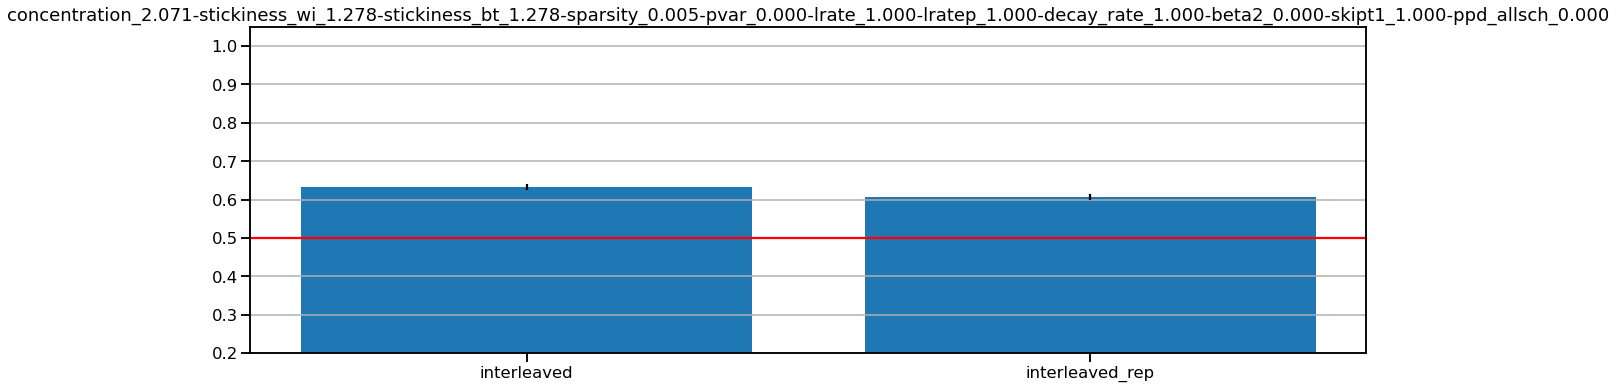

In [10]:
plt.figure(figsize=(20,6))
M = mean_acc[:,-40:].mean(1)
S = mean_acc[:,-40:].std(1)/np.sqrt(ns)
plt.bar(condL,test_acc,yerr=S)
plt.ylim(0.2,1.05)
plt.axhline(0.5,c='r')
plt.title(param_str)
plt.grid(True,axis='y')


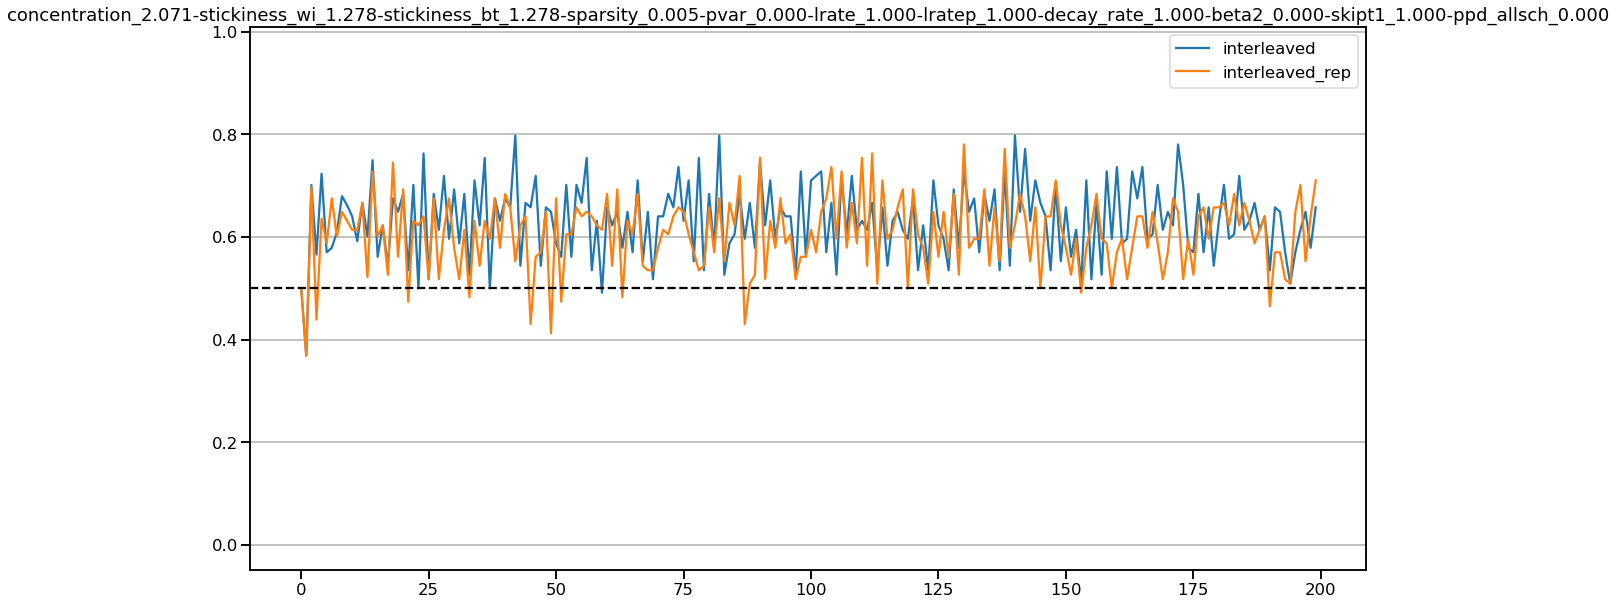

In [11]:
plt.figure(figsize=(20,10))
for idx in range(len(condL)):
  plt.plot(mean_acc[idx],label=condL[idx])
plt.legend()
plt.axhline(0.5,c='k',ls='--')
plt.ylim(-0.05,1.01)
plt.title(param_str)
plt.grid(True,axis='y')

# infered schema

Text(0.5, 1.0, 'concentration_2.071-stickiness_wi_1.278-stickiness_bt_1.278-sparsity_0.005-pvar_0.000-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000-skipt1_1.000-ppd_allsch_0.000')

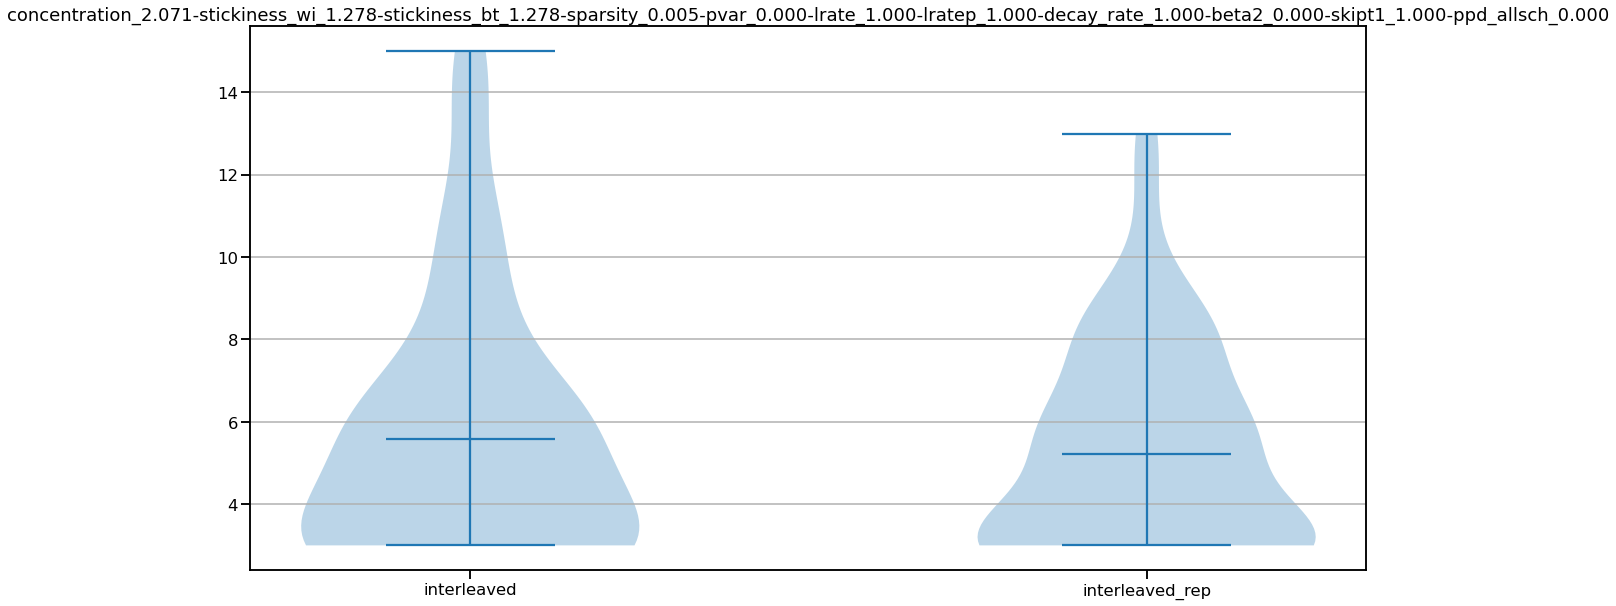

In [12]:
## count number of schemas used
def count_num_schemas(exp_data):
  """ 
  """
  L = []
  for curr_idx in range(len(condL)):
    num_schemas_used = [
      len(np.unique(exp_data[curr_idx][i]['zt'][:,:-1].flatten())
         ) for i in range(ns)
    ]
    L.append(num_schemas_used)
  nschemas = np.array(L)
  return nschemas


nschemas = count_num_schemas(batch_data)
M = nschemas.mean(1)
S = nschemas.std(1)
plt.figure(figsize=(20,10))
plt.title('number schemas used')
plt.violinplot(nschemas.T,np.arange(len(condL)),showmeans=True)
# plt.bar(condL,M,zorder=-100,alpha=0.1)
ax = plt.gca()
ax.set_xticks(range(len(condL)))
ax.set_xticklabels(condL)
plt.grid(True,axis='y')
plt.title(param_str)
# plt.savefig(figdir+'nsch-violin.png')

In [13]:
curr_idx = 0
seed_idx = 1
## 
prior = unpack_data(batch_data,
        dtype='prior')[curr_idx][seed_idx]
like = unpack_data(batch_data,
        dtype='like')[curr_idx][seed_idx]
post = unpack_data(batch_data,
        dtype='post')[curr_idx][seed_idx]
post.shape

(200, 5, 15)

### adjusted rand score

In [14]:
def calc_adjrand(exp_batch_data):
  arscores = -np.ones([len(condL),ns,3])
  for curr_idx in range(len(condL)):
    for seed_idx in range(ns):
      for t_idx,tstep in enumerate([0,2,3]):
        arscores[curr_idx,seed_idx,t_idx] = adjusted_rand_score(
          exp_batch_data[curr_idx][seed_idx]['exp'][:,1],
          exp_batch_data[curr_idx][seed_idx]['zt'][:,tstep]
        )
  return arscores

arscores = calc_adjrand(batch_data)
arscores.shape # cond, seed, tstep

(2, 55, 3)

### save ar scores

In [15]:
np.save("../cswBehavioral/model_data/adjustedRand-topmse%i"%top_mse_k,arscores)

### plt ar

Text(0.5, 0.98, 'concentration_2.071-stickiness_wi_1.278-stickiness_bt_1.278-sparsity_0.005-pvar_0.000-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000-skipt1_1.000-ppd_allsch_0.000')

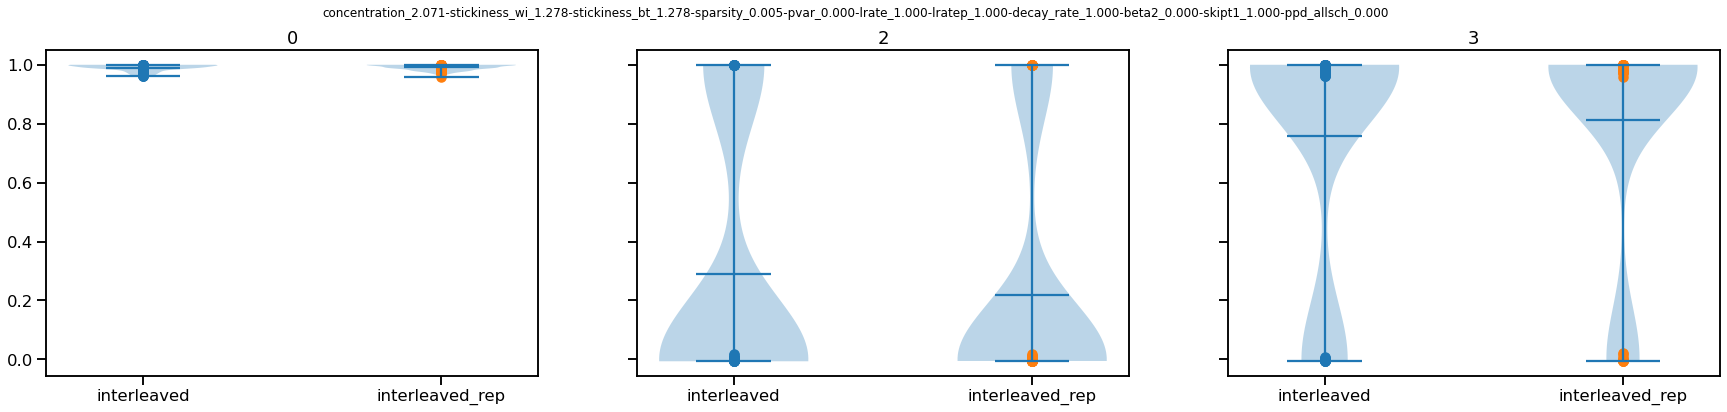

In [16]:
f,axar=plt.subplots(1,3,figsize=(30,6),sharey=True)
for t in range(3):
  ax=axar[t]
  ax.violinplot(arscores[:,:,t].T,showextrema=1,showmeans=1)
  for c in range(len(condL)):
    ax.scatter(np.repeat(c+1,ns),arscores[c,:,t].T)
  ax.set_xticks(np.arange(1,len(condL)+1))
  ax.set_xticklabels(condL)
  ax.set_title(['0','2','3'][t])
plt.suptitle(param_str)

In [17]:
## form seed groups based on LC inference on steps 2 and 3
Iarscores = arscores[0]
print(Iarscores.shape)
goodLCI2 = Iarscores[:,1] >=.99
goodLCI3 = Iarscores[:,2] >=.99
goodLCI23 = np.logical_and(goodLCI2,goodLCI3)
print('good LC2 N=%i, good LC3 N=%i, good LC 2&3 N=%i'%(
  goodLCI2.sum(),goodLCI3.sum(),goodLCI23.sum())
)

(55, 3)
good LC2 N=16, good LC3 N=31, good LC 2&3 N=16
